# Analysis Question-4 Toxicity (Sentiment Analysis)

Toxicity: using Sentiment Analysis, determine the top 5 positive subreddits and top 5 negative subreddits based on comment sentiment.

Choose two subreddits focused on similar topics but with different views, e.g., /r/apple and /r/android. Compare the toxicity of the two.

# What is Sentiment Analysis

![alt text](https://i.imgur.com/MijPBwS.jpg "Logo Title Text 1")

Sentiment analysis is the automatic process of identifying positive, negative and neutral emotions in text. Equipped with AI, sentiment analysis allows businesses to understand how customers feel about their products and services and extract valuable insights that lead to better decision-making.

In a world where we generate 2.5 quintillion bytes of data every day, sentiment analysis has become a key tool for making sense of that data.


# Results 
Lets share with you the results first then we can talk about how we implement it. 

![alt text](https://i.imgur.com/tsNhN6Z.jpg "Logo Title Text 1")


As you can see in the graph above, most positive subreddit is "AskReddit" with 16001 sentiment score. AskReddit is the place to ask and answer thought-provoking questions. Actually, we were expecting that AskReddit will be the one of top but not expecting this much diffence between second top. Second top is "leagueoflegends" with 5536 sentiment score. And gaming, pics, gonewild, IAmA are the following top positive subreddits with 3954,3704,3236,3081 respectively. 
<br> 
On the other hand, top negative subreddit as expected "news" subreddit. "news" subreddit is real news articles, primarily but not exclusively, news relating to the United States and the rest of the World. So world is going crazy and news also. So news has -1589 negative sentiment score. The second top negative subreddit is also related with news "worldnews" with -1358. Third top negative subreddit is de which is related with Germany. We really didn't understand what is going on so bad in Germany. :) Other top negative subreddits are podemos, WTF, argentina, MensRights with -329, -201, -200, -198 respectively.

# Our Implementation

We sampled original data to 1% for first part of this question. 1% data is enough to determine the top 5 positive subreddits and top 5 negative subreddits based on comment sentiment. Important Note: If there are less than 100 comments of a specific subreddit we didn't consider it in this analysis. 

In [1]:
%%time
originDF = sqlContext.read.json("hdfs://orion11:11001/sampled_reddit_v3/*")

CPU times: user 2.08 ms, sys: 1.22 ms, total: 3.3 ms
Wall time: 7.12 s


Cleaning the comment data

In [2]:
import re

def pre_process(text):
    # lowercase
    text=text.lower()
    
    # remove special characters and digits
    text=re.sub("(\\d|[^\\w|\\s]|(\_))+","",text)
    text=re.sub("(\\s)+"," ",text)
    #print(text)
    return text.strip()

We used NLTK /VADER library for Sentiment Analysis.

# Sentiment Analysis

Important Note: If there are less than 100 comments of a specific subreddit we didn't consider it in this analysis. 

In [3]:
import nltk # be sure to have stopwords installed for this using nltk.download_shell()
import string
from pyspark.sql import functions as func
from pyspark.sql import types as types

# This Cell takes 4 minutes... (199923 records for soccer)
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# install Vader and make sure you download the lexicon as well
sid = SentimentIntensityAnalyzer()

def calculatue_score(listBody):    
    #0.1 sample
    #newsamp = sqlDF.filter(sqlDF.subreddit.like(category)&~sqlDF['author'].isin(['[deleted]']))
    
    #0.01 sample
    #newsamp = originDF.filter(originDF.subreddit.like(category)&~originDF['author'].isin(['[deleted]']))
#     newsamp = originDF.filter(originDF['subreddit'].isin(category)&~originDF['author'].isin(['[deleted]']))    
#     iteratebody = newsamp.select("body").rdd.flatMap(list).collect()    
    
    if(len(listBody)>100):                            
        # this step will return an error if you have not installed the lexicon 
        result = 0.0;
        for message in listBody:   
            #clean the comments
            message = pre_process(message)

            ss = sid.polarity_scores(message)
            result += ss["compound"]

        #print(summary)
        return result
    else:
        #print('Sorry less than 100 comments.')
        return 0
    
calculatue_score_udf = func.udf(calculatue_score, types.FloatType())



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home4/saozdamar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Doing sentiment analysis for each subreddit category:

In [5]:
%%time
from pyspark.sql import functions as func

analyzeDF = (originDF.groupBy('subreddit')
.agg(calculatue_score_udf(func.collect_list('body')).alias('analyze'), func.count(func.lit(1)).alias('count')))
analyzeDF = analyzeDF.filter(analyzeDF['count']>=100)
analyzeDF.show()

+-------------------+---------+-----+
|          subreddit|  analyze|count|
+-------------------+---------+-----+
|            Amateur|  24.4157|  153|
|              HPMOR|  22.6543|  162|
|         MLBTheShow|  63.3394|  380|
|         MensRights|-197.9045| 3299|
|         NHLStreams|  28.2473|  171|
|         QuotesPorn|  32.2833|  289|
|       SaltLakeCity|  41.0967|  280|
|UnresolvedMysteries| -21.0719|  461|
|         WahoosTipi|  27.2657|  257|
|              anime| 1483.797| 9240|
|           lacrosse|  27.2878|  110|
|       marvelheroes|  67.5551|  320|
|         mistyfront|   0.3322|  131|
|             travel| 451.8471| 1454|
|            ukraina|  16.0944|  655|
| Anarcho_Capitalism| 120.7049| 1526|
|          BABYMETAL| 108.9668|  390|
|      ClickerHeroes|  90.6882|  357|
|             Hawaii|  45.1344|  237|
|          JUSTNOMIL|  70.3518|  735|
+-------------------+---------+-----+
only showing top 20 rows

CPU times: user 33.8 ms, sys: 6.69 ms, total: 40.5 ms
Wall tim

In [6]:
analyzeDF.schema

StructType(List(StructField(subreddit,StringType,true),StructField(analyze,FloatType,true),StructField(count,LongType,false)))

# Top 5 Positive Subreddits

As you see in the below. Top 5 positive subreddits are "AskReddit", "leagueoflegends", "gaming", "pics" and surpsiringly "gonewild". :)

In [7]:
%%time
analyzeDF.sort(func.col('analyze').desc()).show()

+--------------------+---------+------+
|           subreddit|  analyze| count|
+--------------------+---------+------+
|           AskReddit|16001.021|284960|
|     leagueoflegends| 5536.479| 48008|
|              gaming|3953.6223| 41689|
|                pics|3703.8025| 60123|
|            gonewild|3235.5254| 13058|
|                IAmA| 3080.609| 21385|
|               funny|2940.4287| 64062|
|                 nfl|2826.1062| 32719|
|        pcmasterrace|2776.1965| 18199|
|                 nba| 2721.648| 26823|
|              soccer| 2531.825| 22251|
|               trees|2440.6042| 17487|
|Random_Acts_Of_Am...| 2357.632|  8142|
|            buildapc|2257.9685|  8402|
|               DotA2|2079.6892| 18848|
|              movies|1959.7386| 19706|
|electronic_cigarette|1865.1583|  7779|
|       SquaredCircle|1733.7367| 17271|
|       pokemontrades|1631.5997|  7578|
|              hockey|1625.2948| 17844|
+--------------------+---------+------+
only showing top 20 rows



# Top 5 Negative Subreddits
As you see in the below. Top 5 negative subreddits are news, worldnews, de, podemos, WTF. And top 6th negative is Argentiona?! Oh my god Why? They have Maradona and Messi. They should be happy :P

In [8]:
%%time
analyzeDF.sort(func.col('analyze').asc()).show()

+----------------+----------+-----+
|       subreddit|   analyze|count|
+----------------+----------+-----+
|          Horses|      null|  100|
|      letsgofish|      null|  100|
|       AskNetsec|      null|  100|
|  TACSdiscussion|      null|  100|
|      manchester|      null|  100|
| prisonarchitect|      null|  100|
|            snes|      null|  100|
|             rct|      null|  100|
|     NewMarvelRp|      null|  100|
|           tulsa|      null|  100|
|            news|-1589.3267|24302|
|       worldnews|-1358.1285|34472|
|              de| -493.5001| 1790|
|         podemos| -328.7741| 1635|
|             WTF| -201.3484|35570|
|       argentina| -199.9925| 1710|
|      MensRights| -197.9045| 3299|
|      conspiracy| -182.2452| 5431|
|     JusticePorn| -127.9909| 1669|
|Bad_Cop_No_Donut| -125.2861|  719|
+----------------+----------+-----+
only showing top 20 rows



# Compare 4 Subreddits based on Sentiment Analysis

We decided to compare 4 different cities for Sentiment Analysis. We choosed San Francisco, Los Angeles, San Diego and San Jose. Before comparing the toxicity of these 4 cities we were expecting that San Diego will be most positive city among those 4. So the results didn't surprise us. Most positive city is San Diego and Most negative city is San Francisco. Second positive city is San Jose. So now, instead of staying in SF, we are thinking to move to San Jose :) 

You can see the whole results below pie chart:

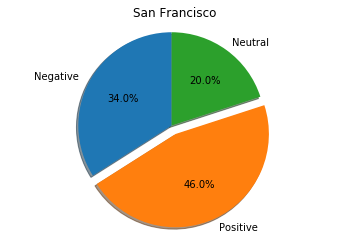

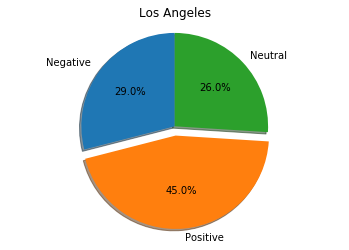

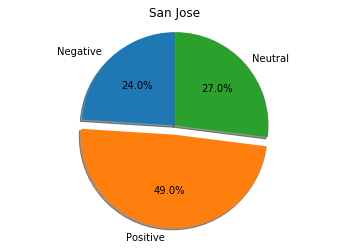

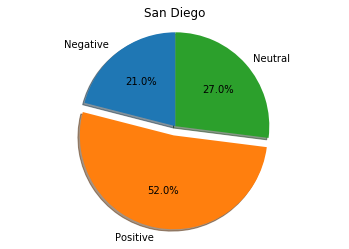

In [11]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative ', 'Positive', 'Neutral'
sizes = [34, 46, 20]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("San Francisco")

plt.show()


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative ', 'Positive', 'Neutral'
sizes = [29, 45, 26]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Los Angeles")

plt.show()

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative ', 'Positive', 'Neutral'
sizes = [24, 49, 27]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("San Jose")

plt.show()


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negative ', 'Positive', 'Neutral'
sizes = [21, 52, 27]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("San Diego")

plt.show()

# Implementation


In [38]:
import nltk # be sure to have stopwords installed for this using nltk.download_shell()
import pandas as pd 
import string

nltk.downloader.download('vader_lexicon')
def calculatue_score2(category):
    newsamp = originDF.filter(originDF.subreddit.like(category)&~originDF['author'].isin(['[deleted]']))
    iteratebody = newsamp.select("body").rdd.flatMap(list).collect()

    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    # install Vader and make sure you download the lexicon as well
    sid = SentimentIntensityAnalyzer()
    # this step will return an error if you have not installed the lexicon
    summary = {"positive":0,"neutral":0,"negative":0}
    summary['category'] = category
    i=0
    for message in tqdm.tqdm((iteratebody)):   
        i=i+1
        #clean the comments
        message = pre_process(message)
        ss = sid.polarity_scores(message)

        if ss["compound"] == 0.0: 
            summary["neutral"] +=1
        elif ss["compound"] > 0.0:
            summary["positive"] +=1
        else:
            summary["negative"] +=1
    
    print('Total comments for ', category , ' is ' , i)
    print(summary)
    return summary

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home4/saozdamar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
%%time
import tqdm
desired_categories = ['sanfrancisco','LosAngeles','SanJose','sandiego']
scores = []
for category in desired_categories:
    print('COMPUTING FOR : ', category)
    scores.append(calculatue_score2(category))
scores

COMPUTING FOR :  sanfrancisco


100%|██████████| 611/611 [00:00<00:00, 2823.09it/s]


Total comments for  sanfrancisco  is  611
{'positive': 282, 'neutral': 120, 'negative': 209, 'category': 'sanfrancisco'}
COMPUTING FOR :  LosAngeles


100%|██████████| 1148/1148 [00:00<00:00, 3286.57it/s]


Total comments for  LosAngeles  is  1148
{'positive': 522, 'neutral': 297, 'negative': 329, 'category': 'LosAngeles'}
COMPUTING FOR :  SanJose


100%|██████████| 115/115 [00:00<00:00, 3466.29it/s]


Total comments for  SanJose  is  115
{'positive': 56, 'neutral': 31, 'negative': 28, 'category': 'SanJose'}
COMPUTING FOR :  sandiego


100%|██████████| 464/464 [00:00<00:00, 3212.02it/s]

Total comments for  sandiego  is  464
{'positive': 243, 'neutral': 123, 'negative': 98, 'category': 'sandiego'}
CPU times: user 836 ms, sys: 13.3 ms, total: 849 ms
Wall time: 18.1 s


[{'positive': 282,
  'neutral': 120,
  'negative': 209,
  'category': 'sanfrancisco'},
 {'positive': 522, 'neutral': 297, 'negative': 329, 'category': 'LosAngeles'},
 {'positive': 56, 'neutral': 31, 'negative': 28, 'category': 'SanJose'},
 {'positive': 243, 'neutral': 123, 'negative': 98, 'category': 'sandiego'}]